In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout , Input , Layer
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
from tensorflow.keras.callbacks import  ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_20ft = pd.read_csv("/content/drive/MyDrive/Freight rate prediction/data/df_20ft_lstm.csv")
df_40ft = pd.read_csv("/content/drive/MyDrive/Freight rate prediction/data/df_40ft_lstm.csv")

In [ ]:
df_20ft.head()

,Date,log_rate,Month_Sin,Month_Cos,Origin_U.S. West Coast (Los Angeles)
0,2012-01-01,6.381816,0.750000,0.933013,1.0
1,2012-02-01,6.381816,0.933013,0.750000,1.0
2,2012-03-01,7.473637,1.000000,0.500000,0.0
3,2012-03-01,6.523562,1.000000,0.500000,1.0
4,2012-04-01,6.608001,0.933013,0.250000,1.0


In [ ]:
 df_20ft.shape
 df_40ft.shape

print("LSTM 20ft shape:", df_20ft.shape)
print("LSTM 40ft shape:", df_40ft.shape)

print("LSTM 20ft head:", df_20ft.head())
print("LSTM 40ft head:", df_40ft.head())

LSTM 20ft shape: (282, 5)
LSTM 40ft shape: (282, 5)
LSTM 20ft head:          Date  log_rate  Month_Sin  Month_Cos  \
0  2012-01-01  6.381816   0.750000   0.933013   
1  2012-02-01  6.381816   0.933013   0.750000   
2  2012-03-01  7.473637   1.000000   0.500000   
3  2012-03-01  6.523562   1.000000   0.500000   
4  2012-04-01  6.608001   0.933013   0.250000   

   Origin_U.S. West Coast (Los Angeles)  
0                                   1.0  
1                                   1.0  
2                                   0.0  
3                                   1.0  
4                                   1.0  
LSTM 40ft head:          Date  log_rate  Month_Sin  Month_Cos  \
0  2012-01-01  6.647688   0.750000   0.933013   
1  2012-02-01  6.647688   0.933013   0.750000   
2  2012-03-01  7.687539   1.000000   0.500000   
3  2012-03-01  6.746412   1.000000   0.500000   
4  2012-04-01  6.814543   0.933013   0.250000   

   Origin_U.S. West Coast (Los Angeles)  
0                               

# Modelling for 20ft container

In [ ]:
def create_sequences(data, target_column, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].drop(columns=['Date']).values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)


In [ ]:
window_size = 12  # number of past months to look back

# Make sequences
X_20ft, y_20ft = create_sequences(df_20ft, target_column='log_rate', window_size=window_size)

# Train-test split (last 12 months as test)
test_size = 12
X_train_20ft, X_test_20ft = X_20ft[:-test_size], X_20ft[-test_size:]
y_train_20ft, y_test_20ft = y_20ft[:-test_size], y_20ft[-test_size:]


In [ ]:
timesteps = X_train_20ft.shape[1]
features = X_train_20ft.shape[2]

model_20ft = Sequential([
    LSTM(64, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.2),
    Dense(1),
])

optimizer = Adam(learning_rate=0.0005)
model_20ft.compile(optimizer=optimizer, loss='mse')
model_20ft.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 12, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_20ft = model_20ft.fit(
    X_train_20ft, y_train_20ft,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 42.8305 - val_loss: 23.9919
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.6791 - val_loss: 9.4042
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8420 - val_loss: 5.1567
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6562 - val_loss: 4.5067
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8841 - val_loss: 3.9742
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4380 - val_loss: 3.5700
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9518 - val_loss: 3.2487
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6920 - val_loss: 2.9624
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3309 - val_loss: 2.7073
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1174 - val_loss: 2.4834
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8412 - val_loss: 2.2810
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - l

In [ ]:
# Predict log_rate
y_pred_20ft_log = model_20ft.predict(X_test_20ft)
y_pred_20ft_log = y_pred_20ft_log[:, -1] # as return_sequences = True

# Flatten pred and true values
y_pred_20ft_log = y_pred_20ft_log.squeeze()
y_test_20ft = y_test_20ft.squeeze()

# Inverse transform using np.expm1(reverse of log1p)
y_pred_20ft = np.expm1(y_pred_20ft_log)
y_true_20ft = np.expm1(y_test_20ft)

mae_20ft = mean_absolute_error(y_true_20ft, y_pred_20ft)
rmse_20ft = np.sqrt(mean_squared_error(y_true_20ft, y_pred_20ft))

print("20ft LSTM MAE:", mae_20ft)
print("20ft LSTM RMSE:", rmse_20ft)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
20ft LSTM MAE: 186.93634033203145
20ft LSTM RMSE: 233.44539104319153


In [ ]:
def plot_graph(y_true , y_pred , C):
  plt.figure(figsize=(10, 5))
  plt.plot(range(len(y_true)), y_true, label='Actual')
  plt.plot(range(len(y_pred)), y_pred, label='Predicted', linestyle='--')
  plt.title(f"{C} LSTM Forecast vs Actual (Test Set)")
  plt.xlabel("Time Step")
  plt.ylabel("Rate")
  plt.legend()
  plt.grid()
  plt.show()


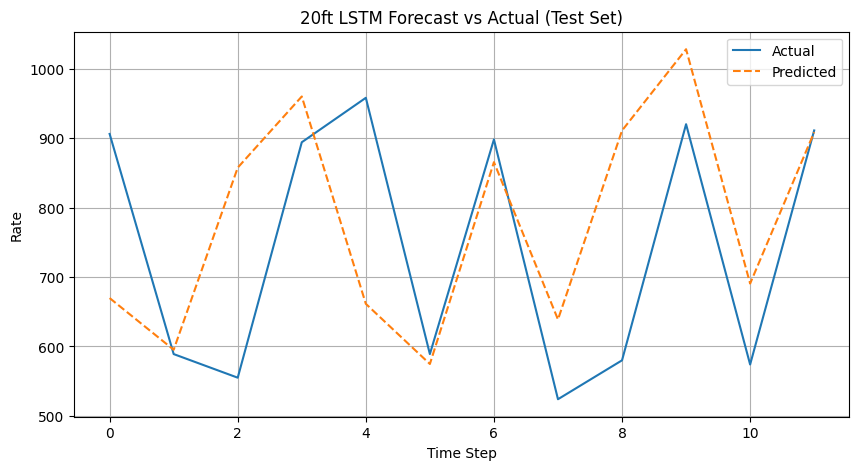

In [ ]:
plot_graph(y_true_20ft ,y_pred_20ft , "20ft")

In [ ]:
# Bidirectional LSTM

In [ ]:
model_20ft = Sequential()
model_20ft.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train_20ft.shape[1], X_train_20ft.shape[2])))
model_20ft.add(Dropout(0.2))
model_20ft.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
model_20ft.compile(optimizer=optimizer, loss='mae')

model_20ft.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 128)            │        35,328 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,457 (138.50 KB)

 Trainable params: 35,457 (138.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history_20ft = model_20ft.fit(
    X_train_20ft, y_train_20ft,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    verbose=1
)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.3394 - val_loss: 2.8941
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1028 - val_loss: 0.7010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5795 - val_loss: 0.3101
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4595 - val_loss: 0.3108
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4169 - val_loss: 0.3242
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5282 - val_loss: 0.3156
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4358 - val_loss: 0.3212
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4654 - val_loss: 0.3444
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4358 - val_loss: 0.3059
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4694 - val_loss: 0.3355
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3999 - val_loss: 0.3069
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [ ]:
y_pred_20ft_log = model_20ft.predict(X_test_20ft)
y_pred_20ft_log = y_pred_20ft_log.flatten()
y_pred_20ft = np.expm1(y_pred_20ft_log)
y_true_20ft = np.expm1(y_test_20ft)

mae_20ft = mean_absolute_error(y_true_20ft, y_pred_20ft)
rmse_20ft = np.sqrt(mean_squared_error(y_true_20ft, y_pred_20ft))
r2_20ft = r2_score(y_true_20ft, y_pred_20ft)

print("🔴Bidirectional LSTM Performance:")
print("MAE:", mae_20ft)
print("RMSE:", rmse_20ft)
print("R² Score:", r2_20ft)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
📊 Bidirectional LSTM Performance:
MAE: 135.60179138183597
RMSE: 180.01642506214893
R² Score: -0.0653619446591629


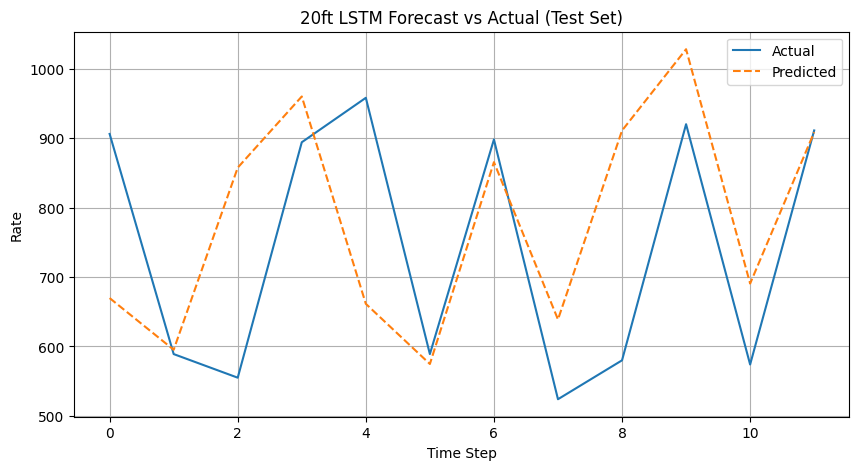

In [ ]:
plot_graph(y_true_20ft ,y_pred_20ft , "20ft")

In [ ]:
# Bidirectional LSTM Performance:
# MAE: 134.96917724609375
# RMSE: 174.60863121252652
# R² Score: -0.0023152302163065297
# mae

# mse
# Bidirectional LSTM Performance:
# MAE: 145.75342305501303
# RMSE: 180.54623736860594
# R² Score: -0.07164217695131869

# Comparision models for 20ft Container


In [ ]:
# Prophet compatible DataFrame
df_prophet = df_20ft[['Date', 'log_rate']].copy()
df_prophet['rate'] = np.expm1(df_prophet['log_rate'])
df_prophet = df_prophet[['Date', 'rate']].rename(columns={'Date': 'ds', 'rate': 'y'})


In [ ]:
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Forecast next 12 months
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
forecast = prophet_model.predict(future)

# predict (last 12 months only)
prophet_pred = forecast[['ds', 'yhat']].tail(12)['yhat'].values


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9kzdnxq/rlyow68v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9kzdnxq/q2_pyvui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59364', 'data', 'file=/tmp/tmps9kzdnxq/rlyow68v.json', 'init=/tmp/tmps9kzdnxq/q2_pyvui.json', 'output', 'file=/tmp/tmps9kzdnxq/prophet_model_4ciej48/prophet_model-20250521201056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
y_pred_lstm_log = model_20ft.predict(X_test_20ft)
y_pred_lstm = np.expm1(y_pred_lstm_log).flatten()
y_true = np.expm1(y_test_20ft)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Ensemble
ensemble_pred = (0.1*prophet_pred + 0.9*y_pred_lstm)


In [2]:
mae = mean_absolute_error(y_true, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))

print("Ensemble (Prophet + LSTM):")
print("Ensemble MAE:", mae)
print("Ensemble RMSE:", rmse)


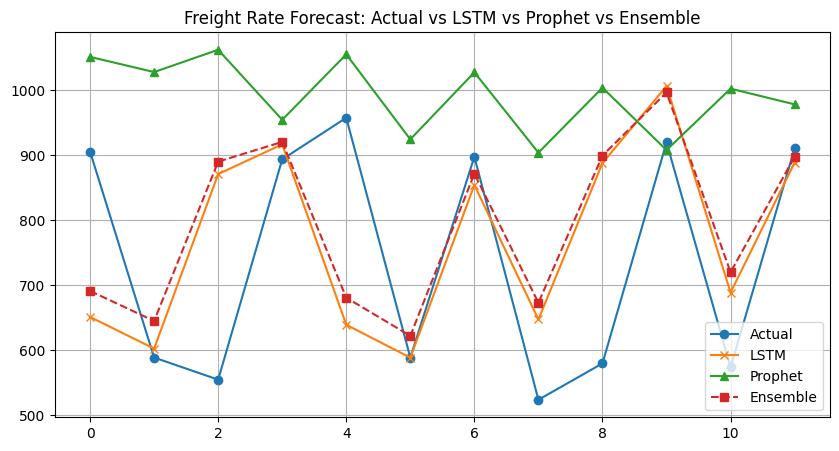

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred_lstm, label='LSTM', marker='x')
plt.plot(prophet_pred, label='Prophet', marker='^')
plt.plot(ensemble_pred, label='Ensemble', linestyle='--', marker='s')
plt.legend()
plt.title("Freight Rate Forecast: Actual vs LSTM vs Prophet vs Ensemble")
plt.grid(True)
plt.show()


In [ ]:
# Stacked Bidirectional LSTM

def build_stacked_bi_lstm(input_shape):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)

    x = Bidirectional(LSTM(32, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    x = Dense(16, activation='relu')(x)
    x = Dense(1)(x)

    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    return model

input_shape = X_train_20ft.shape[1:]  # (sequence_length, num_features)
model_stacked_bi = build_stacked_bi_lstm(input_shape)

model_stacked_bi.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 12, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 12, 128)        │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,601 (303.13 KB)

 Trainable params: 77,601 (303.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)

history = model_stacked_bi.fit(
    X_train_20ft, y_train_20ft,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    callbacks=[ reduce_lr],
    verbose=1
)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 37.9218 - val_loss: 10.4812
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8807 - val_loss: 0.1667
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5467 - val_loss: 0.2254
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4841 - val_loss: 0.1341
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4974 - val_loss: 0.1541
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4499 - val_loss: 0.1859
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5025 - val_loss: 0.1632
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4564 - val_loss: 0.1551
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5525 - val_loss: 0.1695
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4283 - val_loss: 0.1699
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3971 - val_loss: 0.1572
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/st

In [ ]:
y_pred_stacked_log = model_stacked_bi.predict(X_test_20ft)

y_pred_stacked = np.expm1(y_pred_stacked_log)
y_true_stacked = np.expm1(y_test_20ft)

mae = mean_absolute_error(y_true_stacked, y_pred_stacked)
rmse = np.sqrt(mean_squared_error(y_true_stacked, y_pred_stacked))

print("Stacked BiLSTM MAE:", mae)
print("Stacked BiLSTM RMSE:", rmse)
# not better

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Stacked BiLSTM MAE: 299.9615224202476
Stacked BiLSTM RMSE: 338.0550543195575


In [ ]:
# Bidirectional LSTM with attention
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = tf.reduce_sum(x * a, axis=1)
        return output


In [ ]:
def build_bidirectional_lstm_attention(input_shape):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)

    x = Attention()(x)  # Attention layer

    x = Dense(32, activation='relu')(x)
    x = Dense(1)(x)

    model = Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='mse')

    return model


In [ ]:
model_20ft_att = build_bidirectional_lstm_attention(input_shape=(window_size, X_train_20ft.shape[2]))
model_20ft_att.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 12, 128)        │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,629 (154.80 KB)

 Trainable params: 39,629 (154.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_20ft_att.fit(X_train_20ft, y_train_20ft,
                             epochs=100,
                             batch_size=8,
                             validation_split=0.1,
                             verbose=1)



Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.6863 - val_loss: 14.4867
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7465 - val_loss: 0.1684
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2709 - val_loss: 0.1395
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1719 - val_loss: 0.1489
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1453 - val_loss: 0.1349
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1458 - val_loss: 0.1682
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1470 - val_loss: 0.1350
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1503 - val_loss: 0.1448
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1338 - val_loss: 0.1448
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1623 - val_loss: 0.1527
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1578 - val_loss: 0.1424
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

In [ ]:
y_pred_20ft_log = model_20ft_att.predict(X_test_20ft)
y_pred_20ft = np.expm1(y_pred_20ft_log)
y_true_20ft = np.expm1(y_test_20ft)

mae = mean_absolute_error(y_true_20ft, y_pred_20ft)
rmse = np.sqrt(mean_squared_error(y_true_20ft, y_pred_20ft))

print("Bidirectional LSTM + Attention MAE:", mae)
print("Bidirectional LSTM + Attention RMSE:", rmse)
# not better

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Bidirectional LSTM + Attention MAE: 156.0815582275392
Bidirectional LSTM + Attention RMSE: 192.19346771683277


In [ ]:
avg_freight = y_true_20ft.mean()
avg_freight

np.float64(0.36180236349410705)

In [1]:
mae_threshold = 0.10 * avg_freight
print("Average Freight Rate:", avg_freight)
print("MAE:", mae_20ft)
print("Acceptable MAE Threshold:", mae_threshold)
print("RMSE :", rmse_20ft)
print("R² :", r2_20ft)


# Modelling for 40ft container

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 12, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 12, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 37.0820 - val_loss: 15.7047
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 13.7314 - val_loss: 5.9472
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0357 - val_loss: 4.3952
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9098 - val_loss: 3.8645
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3251 - val_loss: 3.4198
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8862 - val_loss: 3.0654
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5053 - val_loss: 2.7558
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2857 - val_loss: 2.4792
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9904 - val_loss: 2.2438
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6920 - val_loss: 2.0334
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5017 - val_loss: 1.8508
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

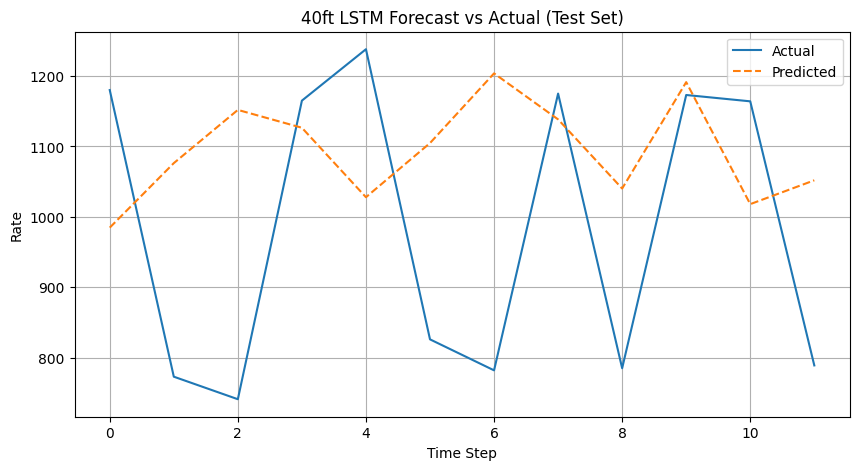

In [ ]:
window_size = 12

X_40ft, y_40ft = create_sequences(df_40ft, target_column='log_rate', window_size=window_size)

test_size = 12
X_train_40ft, X_test_40ft = X_40ft[:-test_size], X_40ft[-test_size:]
y_train_40ft, y_test_40ft = y_40ft[:-test_size], y_40ft[-test_size:]

timesteps = X_train_40ft.shape[1]
features = X_train_40ft.shape[2]

model_40ft = Sequential([
    LSTM(64, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.2),
    Dense(1),
])

optimizer = Adam(learning_rate=0.0005)
model_40ft.compile(optimizer=optimizer, loss='mse')
model_40ft.summary()

history_40ft = model_40ft.fit(
    X_train_40ft, y_train_40ft,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    verbose=1
)

y_pred_40ft_log = model_40ft.predict(X_test_40ft)
y_pred_40ft_log = y_pred_40ft_log[:, -1]
y_pred_40ft_log = y_pred_40ft_log.squeeze()
y_test_40ft = y_test_40ft.squeeze()

y_pred_40ft = np.expm1(y_pred_40ft_log)
y_true_40ft = np.expm1(y_test_40ft)

mae_40ft = mean_absolute_error(y_true_40ft, y_pred_40ft)
rmse_40ft = np.sqrt(mean_squared_error(y_true_40ft, y_pred_40ft))

print("40ft LSTM MAE:", mae_40ft)
print("40ft LSTM RMSE:", rmse_40ft)

plot_graph(y_true_40ft ,y_pred_40ft , "40ft")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 128)            │        35,328 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,457 (138.50 KB)

 Trainable params: 35,457 (138.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.5740 - val_loss: 1.9972
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3144 - val_loss: 0.5112
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4983 - val_loss: 0.2342
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4168 - val_loss: 0.2305
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5052 - val_loss: 0.2315
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4736 - val_loss: 0.2263
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4479 - val_loss: 0.2467
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4330 - val_loss: 0.2237
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3866 - val_loss: 0.2221
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4895 - val_loss: 0.2539
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4111 - val_loss: 0.2314
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - 

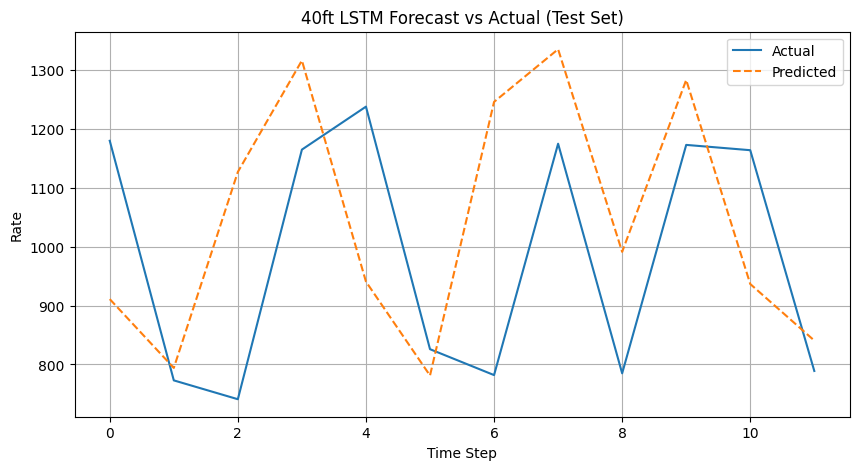

In [ ]:
window_size = 12

X_40ft, y_40ft = create_sequences(df_40ft, target_column='log_rate', window_size=window_size)

test_size = 12
X_train_40ft, X_test_40ft = X_40ft[:-test_size], X_40ft[-test_size:]
y_train_40ft, y_test_40ft = y_40ft[:-test_size], y_40ft[-test_size:]

timesteps = X_train_40ft.shape[1]
features = X_train_40ft.shape[2]

model_40ft = Sequential()
model_40ft.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train_40ft.shape[1], X_train_40ft.shape[2])))
model_40ft.add(Dropout(0.2))
model_40ft.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
model_40ft.compile(optimizer=optimizer, loss='mae')

model_40ft.summary()

history_40ft = model_40ft.fit(
    X_train_40ft, y_train_40ft,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    verbose=1
)

y_pred_40ft_log = model_40ft.predict(X_test_40ft)

y_pred_40ft_log = y_pred_40ft_log.flatten()

y_pred_40ft = np.expm1(y_pred_40ft_log)
y_true_40ft = np.expm1(y_test_40ft)

mae_40ft = mean_absolute_error(y_true_40ft, y_pred_40ft)
rmse_40ft = np.sqrt(mean_squared_error(y_true_40ft, y_pred_40ft))
r2_40ft = r2_score(y_true_40ft, y_pred_40ft)

print("Bidirectional LSTM Performance:")
print("MAE:", mae_40ft)
print("RMSE:", rmse_40ft)
print("R² Score:", r2_40ft)

plot_graph(y_true_40ft ,y_pred_40ft , "40ft")

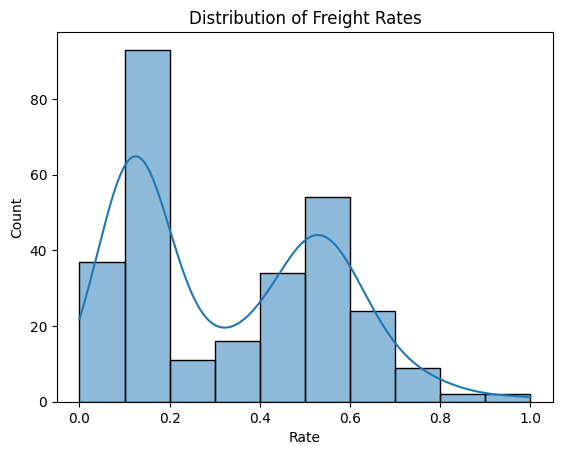

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_20ft['Rate'], kde=True)
plt.title("Distribution of Freight Rates")
plt.show()


# Other Baseline Models

In [ ]:
# For 20ft container

In [ ]:
# Naive forecast: predict the last known value for all test points
y_naive_pred = np.repeat(y_train_20ft[-1], len(y_test_20ft))

y_naive_pred_inv = np.expm1(y_naive_pred)
y_test_inv = np.expm1(y_test_20ft)

mae_naive = mean_absolute_error(y_test_inv, y_naive_pred_inv)
rmse_naive = np.sqrt(mean_squared_error(y_test_inv, y_naive_pred_inv))
r2_naive = r2_score(y_test_inv, y_naive_pred_inv)

print("Naive Forecast")
print("MAE:", mae_naive)
print("RMSE:", rmse_naive)
print("R²:", r2_naive)


Linear Regression Baseline
MAE: 134.18118906739704
RMSE: 168.89902011285315
R²: 0.06216340804030718


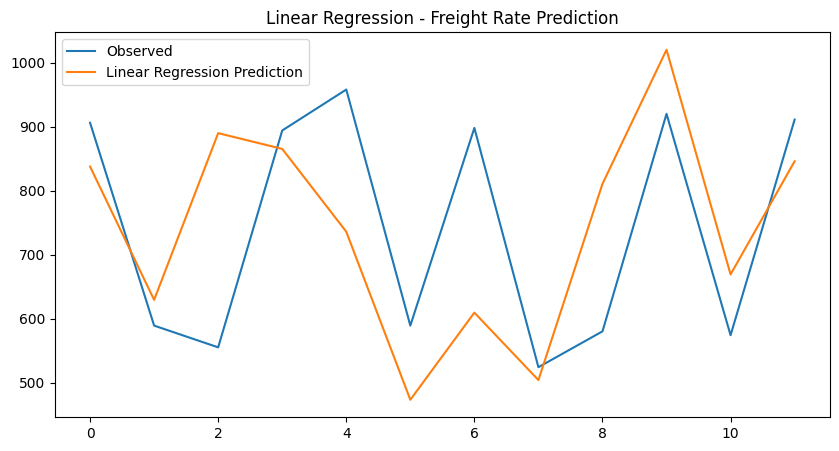

In [ ]:
# Flatten LSTM inputs for regression
X_train_flat = X_train_20ft.reshape(X_train_20ft.shape[0], -1)
X_test_flat = X_test_20ft.reshape(X_test_20ft.shape[0], -1)

lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train_20ft)

y_lr_pred = lr_model.predict(X_test_flat)
y_lr_pred_inv = np.expm1(y_lr_pred)

mae_lr = mean_absolute_error(y_test_inv, y_lr_pred_inv)
rmse_lr = np.sqrt(mean_squared_error(y_test_inv, y_lr_pred_inv))
r2_lr = r2_score(y_test_inv, y_lr_pred_inv)

print("Linear Regression Baseline")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R²:", r2_lr)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Observed")
plt.plot(y_lr_pred_inv, label="Linear Regression Prediction")
plt.title("Linear Regression - Freight Rate Prediction for 20ft")
plt.legend()
plt.show()

XGBoost MAE: 191.85224660237643
XGBoost RMSE: 231.45168699638182


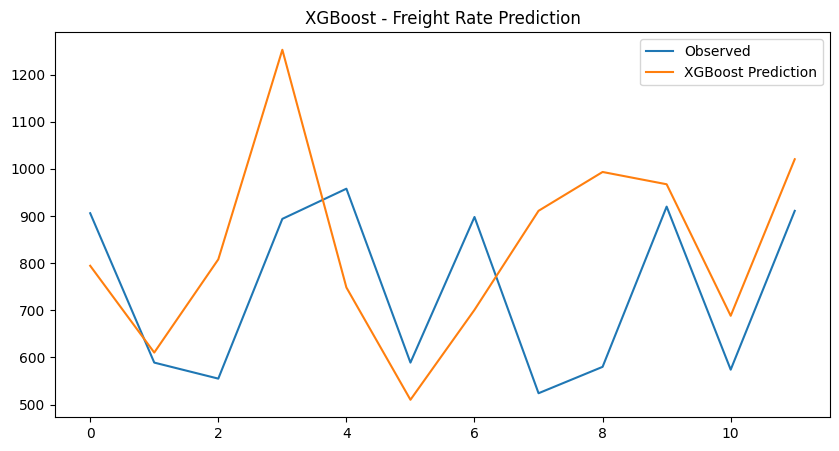

In [ ]:
def create_supervised_data(df, target_column='log_rate', window_size=12):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i - window_size:i][['Month_Sin', 'Month_Cos', 'Origin_U.S. West Coast (Los Angeles)', target_column]].values.flatten())
        y.append(df.iloc[i][target_column])
    return np.array(X), np.array(y)

X_xgb, y_xgb = create_supervised_data(df_20ft, target_column='log_rate', window_size=12)
X_train_xgb, X_test_xgb = X_xgb[:-12], X_xgb[-12:]
y_train_xgb, y_test_xgb = y_xgb[:-12], y_xgb[-12:]


xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_xgb)

y_pred_xgb_log = xgb_model.predict(X_test_xgb)

y_pred_xgb = np.expm1(y_pred_xgb_log)
y_true_xgb = np.expm1(y_test_xgb)

mae_xgb = mean_absolute_error(y_true_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


In [ ]:
# For 40ft Container

In [ ]:
# Naive forecast: predict the last known value for all test points
y_naive_pred = np.repeat(y_train_40ft[-1], len(y_test_40ft))

y_naive_pred_inv = np.expm1(y_naive_pred)
y_test_inv = np.expm1(y_test_40ft)

mae_naive = mean_absolute_error(y_test_inv, y_naive_pred_inv)
rmse_naive = np.sqrt(mean_squared_error(y_test_inv, y_naive_pred_inv))
r2_naive = r2_score(y_test_inv, y_naive_pred_inv)

print("Naive Forecast")
print("MAE:", mae_naive)
print("RMSE:", rmse_naive)
print("R²:", r2_naive)


Naive Forecast
MAE: 173.00000000000009
RMSE: 219.02967835432705
R²: -0.5771712240385931


Linear Regression Baseline
MAE: 134.18118906739704
RMSE: 168.89902011285315
R²: 0.06216340804030718


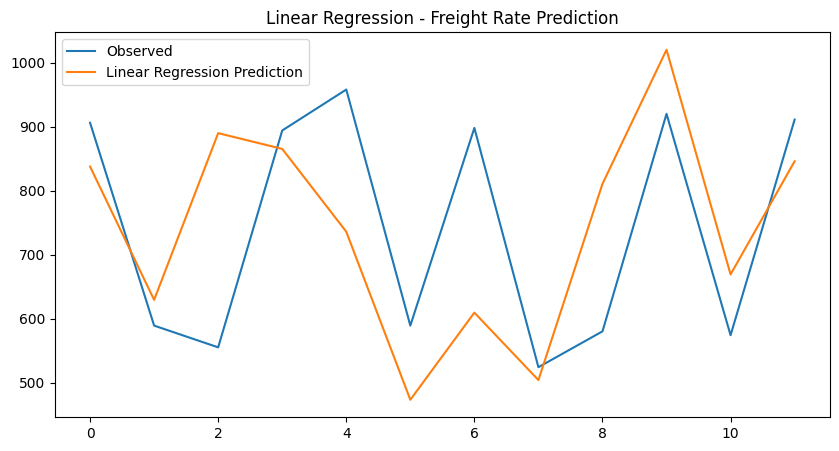

In [ ]:
# Flatten LSTM inputs for regression
X_train_flat = X_train_40ft.reshape(X_train_40ft.shape[0], -1)
X_test_flat = X_test_40ft.reshape(X_test_40ft.shape[0], -1)

lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train_40ft)

y_lr_pred = lr_model.predict(X_test_flat)
y_lr_pred_inv = np.expm1(y_lr_pred)

mae_lr = mean_absolute_error(y_test_inv, y_lr_pred_inv)
rmse_lr = np.sqrt(mean_squared_error(y_test_inv, y_lr_pred_inv))
r2_lr = r2_score(y_test_inv, y_lr_pred_inv)

print("Linear Regression Baseline")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R²:", r2_lr)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="Observed")
plt.plot(y_lr_pred_inv, label="Linear Regression Prediction")
plt.title("Linear Regression - Freight Rate Prediction for 40ft")
plt.legend()
plt.show()

XGBoost MAE: 172.16158040364576
XGBoost RMSE: 212.2822215202448


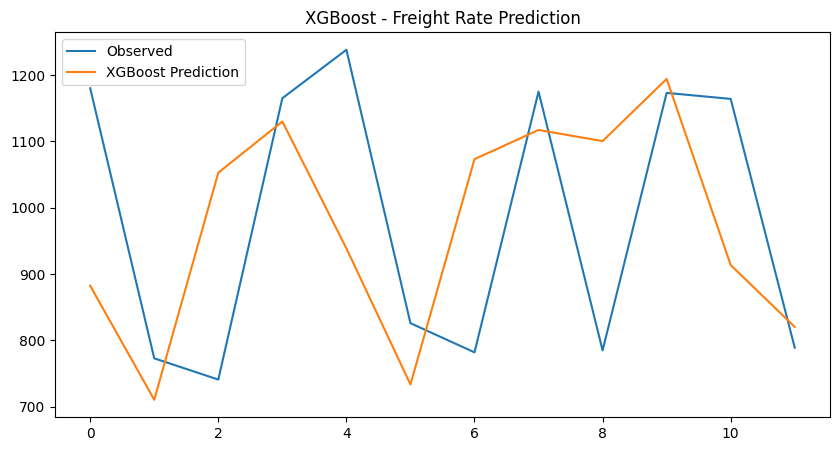

In [ ]:
X_xgb, y_xgb = create_supervised_data(df_40ft, target_column='log_rate', window_size=12)
X_train_xgb, X_test_xgb = X_xgb[:-12], X_xgb[-12:]
y_train_xgb, y_test_xgb = y_xgb[:-12], y_xgb[-12:]

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_xgb)

y_pred_xgb_log = xgb_model.predict(X_test_xgb)

y_pred_xgb = np.expm1(y_pred_xgb_log)
y_true_xgb = np.expm1(y_test_xgb)

mae_xgb = mean_absolute_error(y_true_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)
